In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sstools as ss
%matplotlib inline
sns.set_style('darkgrid')

# Let's generate some data from a state space model

In [2]:
np.random.seed(12345)  # set random seed

We'll generate data according to a simple state space model and then recover the underlying model via the Kalman filter/smoother. We follow the conventions of [Durbin and Koopman (2012)](http://www.ssfpack.com/DKbook.html).

### Observation model

$$\begin{align}
y_t &= Z_t \alpha_t + \varepsilon_t \\
\varepsilon_t &\sim \mathcal{N}(0, H_t)
\end{align}$$

In [3]:
Z = np.array([[1, -1], [0, 1], [1, 0]])  # observation matrix
H = 0.1 * np.array([[1, 0, 0], [0, 1, 0.2], [0, 0.2, 1]])

Np, Nm = Z.shape

In [4]:
assert(H.shape == (Np, Np))

### State evolution model

$$\begin{align}
\alpha_{t+1} &= T_t \alpha_t + R_t \eta_t \\
\eta_t &\sim \mathcal{N}(0, Q_t)
\end{align}$$

In [5]:
th = 10 * np.pi / 180  # rotation angle
T = np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]])  # rotation matrix
R = np.array([1.1, 1])[:, np.newaxis]
Q = np.array([0.05])[:, np.newaxis]

_, Nr = R.shape

In [6]:
assert(T.shape == (Nm, Nm))
assert(R.shape[0] == Nm)
assert(Q.shape == (Nr, Nr))

### Prior

$$
\alpha_1 \sim \mathcal{N}(a_1, P_1)
$$

In [7]:
a_init = np.zeros(Nm)
P_init = 5 * np.eye(Nm)

In [8]:
assert(P_init.shape == (Nm, Nm))

## Now generate some data

In [9]:
Ny = 100  # number of samples

Preallocate data arrays:

In [10]:
alpha = np.empty((Ny, Nm))
y = np.empty((Ny, Np))
eps = np.empty((Ny, Np))
eta = np.empty((Ny, Nr))

Initialize:

In [11]:
alpha[0] = np.random.multivariate_normal(a_init, P_init)

In [12]:
for t in range(Ny):
    eps[t] = np.random.multivariate_normal(np.zeros(Np), H)
    eta[t] = np.random.multivariate_normal(np.zeros(Nr), Q)
    y[t] = Z.dot(alpha[t]) + eps[t]
    if t + 1 < Ny:
        alpha[t + 1] = T.dot(alpha[t]) + R.dot(eta[t])

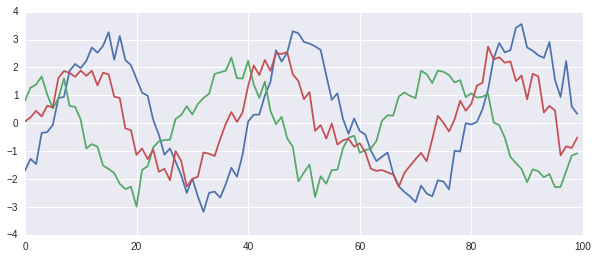

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(y);

# Kalman filter (forward)

Now filter! In DK conventions, this is
$$\begin{align}
v_t &= y_t - Z_t a_t  \\
F_t &= Z_t P_t Z_t^\top + H_t  \\
aa \equiv \mathbb{E}(\alpha_t\vert y_{1:t}) &= a_t + P_t Z_t^\top F_t^{-1} v_t  \\
PP \equiv \mathrm{var}(\alpha_t \vert y_{1:t}) &= P_t - P_t Z_t^\top F_t^{-1} Z_t P_t  \\
K_t &= T_t P_t Z_t^\top F_t^{-1}  \\
L_t &= T_t - K_t Z_t  \\
a_{t + 1} &= T_t a_t + K_t v_t  \\
P_{t + 1} &= T_t P_t(T_t - K_t Z_t)^\top + R_t Q_t R_t^\top
\end{align}$$

Preallocate some arrays for the filter.

In [14]:
a = np.empty((Ny, Nm))
P = np.empty((Ny, Nm, Nm))
aa = np.empty((Ny, Nm))
PP = np.empty((Ny, Nm, Nm))
v = np.empty((Ny, Np))
F = np.empty((Ny, Np, Np))
K = np.empty((Ny, Nm, Np))
L = np.empty((Ny, Nm, Nm))

Set some priors:

In [15]:
a[0] = a_init
P[0] = P_init

In [16]:
for t in range(Ny):
    v[t] = y[t] - Z.dot(a[t])
    F[t] = Z.dot(P[t]).dot(Z.T) + H
    Finv = np.linalg.inv(F[t])
    aa[t] = a[t] + P[t].dot(Z.T).dot(Finv).dot(v[t])
    PP[t] = P[t] - P[t].dot(Z.T).dot(Finv).dot(Z).dot(P[t])
    K[t] = T.dot(P[t]).dot(Z.T).dot(Finv)
    L[t] = T - K[t].dot(Z)
    if t + 1 < Ny:
        a[t + 1] = T.dot(a[t]) + K[t].dot(v[t])
        P[t + 1] = T.dot(P[t]).dot(L[t].T) + R.dot(Q).dot(R.T)

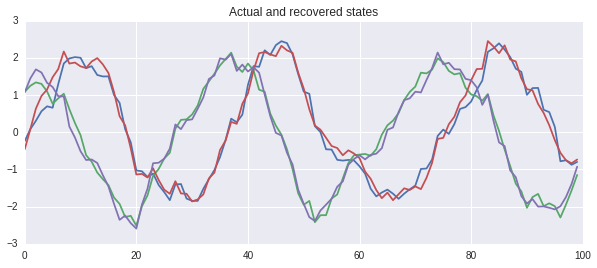

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(aa)
plt.plot(alpha)
plt.title('Actual and recovered states')
pass

# Kalman smoother (backward)

First define the posterior of the state vector given all the data as
$$\begin{align}
p(\alpha_t \vert y_{1:N}) = \mathcal{N}(\hat{\alpha}_t, V_t) 
\end{align}$$

The recursions for the smoothed state $\hat{\alpha}$ are then

$$\begin{align}
r_n &= 0  \\
N_n &= 0  \\
r_{t - 1} &= Z_t^\top F_t^{-1} v_t + L_t^\top r_t  \\
N_{t - 1} &= Z_t^\top F_t^{-1} Z_t + L_t^\top N_t L_t  \\
\hat{\alpha}_t &= a_t + P_t r_{t - 1}  \\
V_t &= P_t - P_t N_{t - 1} P_t
\end{align}$$

Now, preallocate some arrays and initialize:

In [18]:
r = np.empty((Ny, Nm))
ahat = np.empty((Ny, Nm))
N = np.empty((Ny, Nm, Nm))
V = np.empty((Ny, Nm, Nm))

ahat[0] = a_init
V[0] = P_init
r[-1] = 0
N[-1] = 0

In [19]:
for t in range(Ny - 1, 0, -1):
    Finv = np.linalg.inv(F[t])
    
    r[t - 1] = Z.T.dot(Finv).dot(v[t]) + L[t].T.dot(r[t])
    N[t - 1] = Z.T.dot(Finv).dot(Z) + L[t].T.dot(N[t]).dot(L[t])
    ahat[t] = a[t] + P[t].dot(r[t - 1])
    V[t] = P[t] - P[t].dot(N[t - 1]).dot(P[t])

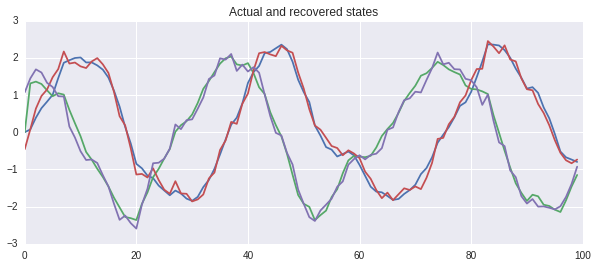

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(ahat)
plt.plot(alpha)
plt.title('Actual and recovered states')
pass

# Disturbance smoother/fast state smoother

As an alternative to the Kalman smoother, Durbin and Koopman recommend a disturbance smoother for the noise terms $\varepsilon$ and $\eta$. This recursion has lower memory requirements (using only $v_t$, $F_t$, and $K_t$) and does not require multiplication by the often dense $a_t$ and $P_t$. 

This system of recursions (for the posterior means) is given by

$$\begin{align}
u_t &= F_t^{-1} v_t - K_t^\top r_t  \\
\hat{\varepsilon}_t &= H_t u_t  \\
\hat{\eta}_t &= Q_t R_t^\top r_t  \\
r_{t - 1} &= Z_t^\top u_t + T_t^\top r_t
\end{align}$$

with additional recursions for the variances (cf. Durbin and Koopman 4.5.3).

These recursions provide a particularly efficient means of calculating the smoothed state estimates $\hat{\alpha}_t$:

$$\begin{align}
\hat{\alpha}_1 &= a_1 + P_1 r_0  \\
\hat{\alpha}_{t + 1} &= T_t \hat{\alpha}_t + R_t Q_t R_t^\top r_t
\end{align}$$

This takes advantage of the typical sparsity of $T$ and $RQR$. However, it does not lend itself to calculating the posterior smoothed variances $V$.

Thus, if we only care about the posterior smoothed state means, we can do so very efficiently by saving only $F$, $K$,  and $v$ from the filtering step, calculate $r$ from the recursion using $u$ above, and run the model forward in time to get $\hat{\alpha}$.

### Implementation of the fast state smoother

First, we initialize $r$ and $\hat{\alpha}$:

In [21]:
# initialize r
r = np.empty((Ny, Nm))
r[-1] = 0
alphat = np.empty((Ny, Nm))

Then we recursively calculate $r$, working backward in time:

In [22]:
# calculate r
for t in range(Ny - 1, -1, -1):
    Finv = np.linalg.inv(F[t])
    
    u = Finv.dot(v[t]) - K[t].T.dot(r[t])
    thisr = Z.T.dot(u) + T.T.dot(r[t])
    if t > 0:
        r[t - 1] = thisr
    else:
        r_init = thisr
    

Finally, we run the state space model forward in time

In [23]:
# run model forward
alphat[0] = a_init + P_init.dot(r_init)
RQR = R.dot(Q).dot(R.T)

for t in range(0, Ny - 1):
    alphat[t + 1] = T.dot(alphat[t]) + RQR.dot(r[t])

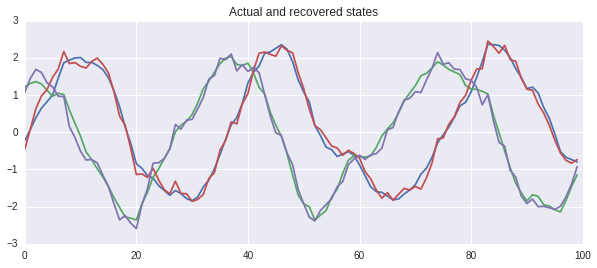

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(alphat)
plt.plot(alpha)
plt.title('Actual and recovered states')
pass

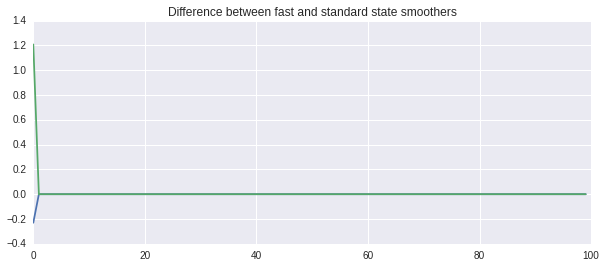

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(alphat - ahat)
plt.title('Difference between fast and standard state smoothers')
pass

# Drawing posterior samples (simulation smoothing)

We want to be able to sample from the smoothed posterior for the states, $p(\alpha_t|y_{1:N})$. We can do this using the technique of [Durbin and Koopman (2002)](http://biomet.oxfordjournals.org/content/89/3/603.short), which involves following steps:

1. Draw disturbance terms ($\varepsilon$ and $\eta$) from the *prior*, denoted $w^+$.
1. Simulate the model using these disturbances, generating a state sequence, $\alpha^+$ and observations $y^+$.
1. Using the Kalman filter and smoother, calculate smoothed estimates of the state sequence conditioned
    on the actual and the simulated data, $\hat{\alpha} = \mathbb{E}(\alpha|y_{1:n})$ and 
    $\hat{\alpha}^+ = \mathbb{E}(\alpha|y^+_{1:n})$.
1. Combine these estimates with the simulated state sequence. The result, 
    $\alpha^+ - \hat{\alpha}^+ + \hat{\alpha}$, is a draw from the posterior.
   

## Implementing the posterior sampler

Preallocate arrays:

In [26]:
alpha_plus = np.empty((Ny, Nm))
y_plus = np.empty((Ny, Np))

### Draw disturbances

In [27]:
eps_sim = np.random.multivariate_normal(np.zeros(Np), H, Ny)
eta_sim = np.random.multivariate_normal(np.zeros(Nr), Q, Ny)

### Simulate model

In [28]:
alpha_plus[0] = np.random.multivariate_normal(a_init, P_init)

for t in range(Ny):
    y_plus[t] = Z.dot(alpha_plus[t]) + eps_sim[t]
    if t + 1 < Ny:
        alpha_plus[t + 1] = T.dot(alpha_plus[t]) + R.dot(eta_sim[t])

### Get smoothed means

Now run the data through:

In [29]:
vv, KK, FFinv = ss.kalman_filter(y, a_init, P_init, Z, H, T, R, Q)
alpha_hat = ss.fast_state_smoother(vv, KK, FFinv, a_init, P_init, Z, T, R, Q)

In [30]:
vv, KK, FFinv = ss.kalman_filter(y_plus, a_init, P_init, Z, H, T, R, Q)
alpha_hat_plus = ss.fast_state_smoother(vv, KK, FFinv, a_init, P_init, Z, T, R, Q)

### And combine...

In [31]:
alpha_draw = alpha_plus - alpha_hat_plus + alpha_hat

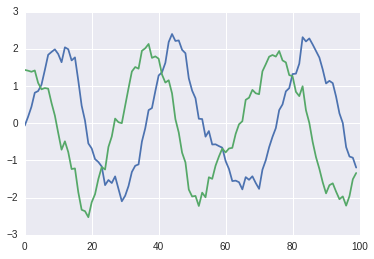

In [32]:
plt.plot(alpha_draw)
pass

### Let's pull this into a function:

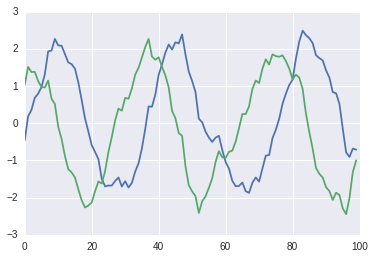

In [33]:
adraw = ss.simulate(y, a_init, P_init, Z, H, T, R, Q)
plt.plot(adraw)
pass

# Let's make a posterior

In [34]:
Ns = 1000  # number of samples

alpha_samples = np.empty((Ns, Ny, Nm))

In [35]:
for idx in range(Ns):
    alpha_samples[idx] = ss.simulate(y, a_init, P_init, Z, H, T, R, Q)

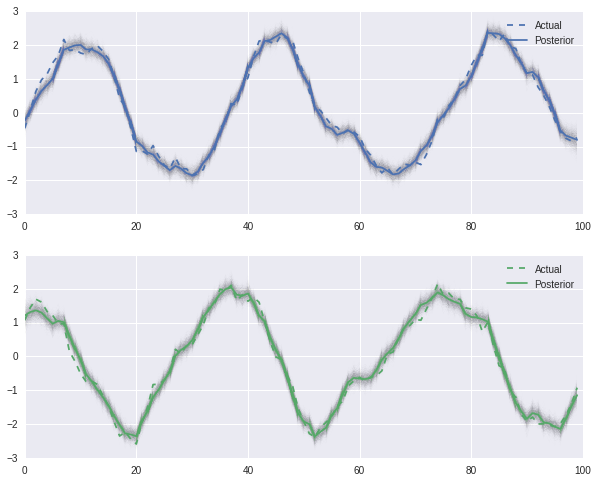

In [36]:
trans = 5 / Ns
plt.figure(figsize=(10, 8))

for idx in range(Nm):
    plt.subplot(Nm, 1, idx + 1)
    plt.plot(alpha_samples[..., idx].T, color=sns.color_palette()[idx], alpha=trans)
    plt.plot(alpha[..., idx], color=sns.color_palette()[idx], linestyle='--', label='Actual')
    plt.plot(alphat[..., idx], color=sns.color_palette()[idx], label='Posterior')
    plt.legend()
pass